# Quanitifed Self Project

Katie Imhof and John Stirrat
CPSC 222, Fall 21

### Introduction

* The domain that we chose to look at for this project is our Spotify listening data. The reasons we decided to use this domain was because we both enjoy listening to music a lot, and thought it would be interesting to analyze our listening habits, since we both spend a lot of time using Spotify.
* The data from Spotify is in JSON files.
* There is one table from this dataset, and it is collected whenever a song is listened too, where all of the attributes (listed below) are recorded. 
* The attributes this data has are:
    * Date and End time (which we will split and use as two seperate attributes)
        * Continuous and interval
    * Artist Name
        * Categorical/discrete and nominal
    * Track Name
        * Categorical/discrete and nominal
    * Time played in Ms
        * Continuous and interval
* We are interested in trying to classify the amount of time spent listening based on external factors.
* The impact of our results could lead to change in our listening habits, and could also help us understand why we listen to music more than other times.
* Potential stakeholders that could be interested in our results could be businesses like radio stations, stores, restaurants, etc, since they could potentially find the best times to play ads since they will see what factors influence listening time, so they may have an interest in our project.


### Data Analysis

#### Loading and Cleaning Data:

The cleaning that I did was to separate the "endTime" attribute into the separate date and end time values, since they will be more usable and relevant if they are separate. We will also use date as a foreign key to join tables in the future, so it will be better if that is its own column.

In [62]:
import utils
import pandas as pd

john_stream_hist_df = utils.get_spotify_df("JohnStreamingHistory0.json")

katie_stream_hist_df = utils.get_spotify_df("KatieStreamingHistory0.json")

#### Hypothesis Testing

Problem:
* Using the Spotify data, is the mean amount of time (in milliseconds) John listened to music between November 2020 and January 2021 greater than the mean amount of time Katie listened to music between November 2020 and January 2021?

Type of Hypothesis T-Test:
* An independent, two sample, one-tailed test will be performed. It's an independent test because the two groups didn't have an affect on each other, they are unrelated. It's a two sample test because there are two groups. It's a one-tailed test because we are comparing the mean amount of time listened of the two groups. A one-tailed test will be more helpful because we want $H_1$ to state a direction.

##### Step 1: State the null and alternate hypothesis

$H_0$: $\mu_{John}\leq \mu_{Katie}$


$H_1$: $\mu_{John} > \mu_{Katie}$

##### Step 2: Select the level of significance

$\alpha$ = 0.05

##### Step 3: Select the appropriate test statistic

$t=\frac{\overline{X_{John}} - \overline{X_{Katie}}}{\sqrt{s_p^2(\frac{1}{n_{John}}+\frac{1}{n_{Katie}})}}$

##### Step 4: Formulate the decision rule

First, we need to grab the dates we want which is November 2020 to January 2021, two months worth of data.

In [63]:
katie_date_df = katie_stream_hist_df["2020-11-01":"2021-01-01"]
john_date_df = john_stream_hist_df["2020-11-01":"2021-01-01"]

Now we want to grab the "msPlayed" column to grab the amount of music we listened to during those months.

In [64]:
katie_ms_played = katie_date_df["msPlayed"]
john_ms_played = john_date_df["msPlayed"]

Next, we need to find n for each group (the total amount of days that we're using).

In [65]:
n_katie = len(katie_ms_played)
n_john = len(john_ms_played)

In [66]:
df = n_katie + n_john - 2
print("df:", df)

df: 5627


Since it's a one-tailed test, $\alpha$ = 0.05 and df = 5627

Looking at the t-table, t-critical is 1.645.

If t-computed > 1.645, then reject $H_0$.

If t-computed <= 1.645, do not reject $H_0$.

### Step 5: Make a decision

Using SciPy, we will now calculate t-computed.

In [67]:
import scipy.stats as stats

t, p = stats.ttest_ind(john_ms_played, katie_ms_played)
print("t:", t, "p:", p / 2)

t: 6.863307298918676 p: 3.7260903946574615e-12


Since t-computed (6.86) > t-critical (1.645), reject $H_0$, $\mu_{John} > \mu_{Katie}$.

Also, p-value < $\alpha$ (0.05) => reject $H_0$.

Conclusion:
* At the 0.05 level of significance, the mean amount of time (in milliseconds) that John listened to music between November 2020 and January 2021 appears to be greater than the mean amount of time Katie listened to music between November 2020 and January 2021.

#### Visualizations

In order to display the data in a way that's easy to understand, we're going to convert the amount of time from milliseconds to seconds of the sample means.

In [68]:
import numpy as np

Xbar_john = np.mean(john_ms_played)
Xbar_katie = np.mean(katie_ms_played)

Xbar_seconds_john = Xbar_john / 1000
Xbar_seconds_katie = Xbar_katie / 1000

To show John's mean compared to Katie's mean, we are going to use a pie chart, using the matplotlib library.

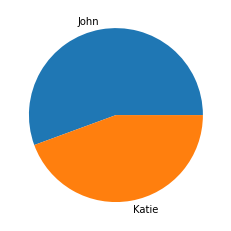

In [69]:
import matplotlib.pyplot as plt

means_list = [Xbar_seconds_john, Xbar_seconds_katie]
label = ["John", "Katie"]

plt.pie(means_list, labels=label)
plt.show()

On average, John listens to music more often than Katie.

# kNN Classification

For this classification task, we will be training a kNN classifier to see if it can accurately predict what day of the week a song is listened to on based on what time of day the song is listened to. To do this, we will use the endTime attribute, since it is recorded as a time of day, and so we can use this to see what time of day we listened to a song on a certain day.

To do this, the first step is to join our data with a table that contains the day of the week for a certain date. We used the table of date provided for DA3 for the days of the week.   
The problem with using this table was, however, that the date was provided in this table was in a different format than the Spotify datasets, so we had to reformat it so it would match, and then could be used to join the two tables.

Another problem was that the time of day was presented as a string, so we went through and decoded it to a numerical value. We also condensed each time into the hour of the day it was to help make the data easier to understand and use in the classifier

In [70]:
days_df = pd.read_csv("days_of_week.csv")

for i in range(len(days_df["Date"])):
    item_list = days_df["Date"][i].split("/")
   
    for j in range(len(item_list)):
        for num in range(1, 10, 1):
            if item_list[j] == str(num):
                item_list[j] = "0" + str(num)

    days_df["Date"][i] = "20" + item_list[2] + "-" + item_list[0] + "-" + item_list[1]
    

days_df.set_index("Date", inplace=True)

john_weekday_df = john_date_df.join(days_df)
katie_weekday_df = katie_date_df.join(days_df)

for i in range(len(john_weekday_df["endTime"])):
    item_list = john_weekday_df["endTime"][i].split(":")
    if item_list[0] == "01":
        john_weekday_df["endTime"][i] = 1
    elif item_list[0] == "02":
        john_weekday_df["endTime"][i] = 2
    elif item_list[0] == "03":
        john_weekday_df["endTime"][i] = 3
    elif item_list[0] == "04":
        john_weekday_df["endTime"][i] = 4
    elif item_list[0] == "05":
        john_weekday_df["endTime"][i] = 5
    elif item_list[0] == "06":
        john_weekday_df["endTime"][i] = 6
    elif item_list[0] == "07":
        john_weekday_df["endTime"][i] = 7
    elif item_list[0] == "08":
        john_weekday_df["endTime"][i] = 8
    elif item_list[0] == "09":
        john_weekday_df["endTime"][i] = 9
    elif item_list[0] == "10":
        john_weekday_df["endTime"][i] = 10
    elif item_list[0] == "11":
        john_weekday_df["endTime"][i] = 11
    elif item_list[0] == "12":
        john_weekday_df["endTime"][i] = 12
    elif item_list[0] == "13":
        john_weekday_df["endTime"][i] = 13
    elif item_list[0] == "14":
        john_weekday_df["endTime"][i] = 14
    elif item_list[0] == "15":
        john_weekday_df["endTime"][i] = 15
    elif item_list[0] == "16":
        john_weekday_df["endTime"][i] = 16
    elif item_list[0] == "17":
        john_weekday_df["endTime"][i] = 17
    elif item_list[0] == "18":
        john_weekday_df["endTime"][i] = 18
    elif item_list[0] == "19":
        john_weekday_df["endTime"][i] = 19
    elif item_list[0] == "20":
        john_weekday_df["endTime"][i] = 20
    elif item_list[0] == "21":
        john_weekday_df["endTime"][i] = 21
    elif item_list[0] == "22":
        john_weekday_df["endTime"][i] = 22
    elif item_list[0] == "23":
        john_weekday_df["endTime"][i] = 23
    elif item_list[0] == "24":
        john_weekday_df["endTime"][i] = 24
    elif item_list[0] == "00":
        john_weekday_df["endTime"][i] = 0

for i in range(len(katie_weekday_df["endTime"])):
    item_list = katie_weekday_df["endTime"][i].split(":")
    if item_list[0] == "01":
        katie_weekday_df["endTime"][i] = 1
    elif item_list[0] == "02":
        katie_weekday_df["endTime"][i] = 2
    elif item_list[0] == "03":
        katie_weekday_df["endTime"][i] = 3
    elif item_list[0] == "04":
        katie_weekday_df["endTime"][i] = 4
    elif item_list[0] == "05":
        katie_weekday_df["endTime"][i] = 5
    elif item_list[0] == "06":
        katie_weekday_df["endTime"][i] = 6
    elif item_list[0] == "07":
        katie_weekday_df["endTime"][i] = 7
    elif item_list[0] == "08":
        katie_weekday_df["endTime"][i] = 8
    elif item_list[0] == "09":
        katie_weekday_df["endTime"][i] = 9
    elif item_list[0] == "10":
        katie_weekday_df["endTime"][i] = 10
    elif item_list[0] == "11":
        katie_weekday_df["endTime"][i] = 11
    elif item_list[0] == "12":
        katie_weekday_df["endTime"][i] = 12
    elif item_list[0] == "13":
        katie_weekday_df["endTime"][i] = 13
    elif item_list[0] == "14":
        katie_weekday_df["endTime"][i] = 14
    elif item_list[0] == "15":
        katie_weekday_df["endTime"][i] = 15
    elif item_list[0] == "16":
        katie_weekday_df["endTime"][i] = 16
    elif item_list[0] == "17":
        katie_weekday_df["endTime"][i] = 17
    elif item_list[0] == "18":
        katie_weekday_df["endTime"][i] = 18
    elif item_list[0] == "19":
        katie_weekday_df["endTime"][i] = 19
    elif item_list[0] == "20":
        katie_weekday_df["endTime"][i] = 20
    elif item_list[0] == "21":
        katie_weekday_df["endTime"][i] = 21
    elif item_list[0] == "22":
        katie_weekday_df["endTime"][i] = 22
    elif item_list[0] == "23":
        katie_weekday_df["endTime"][i] = 23
    elif item_list[0] == "24":
        katie_weekday_df["endTime"][i] = 24
    elif item_list[0] == "00":
        katie_weekday_df["endTime"][i] = 0

<ipython-input-70-5e5e604f0536>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  john_weekday_df["endTime"][i] = 1
<ipython-input-70-5e5e604f0536>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  john_weekday_df["endTime"][i] = 2
<ipython-input-70-5e5e604f0536>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  john_weekday_df["endTime"][i] = 19
<ipython-input-70-5e5e604f0536>:62: SettingWithCopyWarning: 
A value is trying to be set o

Now that the data is useable, we can now set up the classifier and do the classification

Before doing it, the hypothesis that we had was that trying to classify the Day of Week attribute may not be that accurate, since there likely may not be a large difference in our listening habits from day to day, and so this may not work well.

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_john = john_weekday_df.drop("Day of Week", axis=1)
X_john = X_john.drop("artistName", axis=1)
X_john = X_john.drop("trackName", axis=1)
#X_john = X_john.drop("msPlayed", axis=1)
y_john = john_weekday_df["Day of Week"]

X_john = scaler.fit_transform(X_john)

X_train_john, X_test_john, y_train_john, y_test_john = train_test_split(X_john, y_john, random_state=0, stratify=y_john)

knn_clf_john = KNeighborsClassifier(n_neighbors=50, metric="euclidean")
knn_clf_john.fit(X_train_john, y_train_john)

y_predicted_john = knn_clf_john.predict(X_test_john)

accuracy = knn_clf_john.score(X_test_john, y_test_john)
print("John kNN Accuracy: ", accuracy)

X_katie = katie_weekday_df.drop("Day of Week", axis=1)
X_katie = X_katie.drop("artistName", axis=1)
X_katie = X_katie.drop("trackName", axis=1)
#X_katie = X_katie.drop("msPlayed", axis=1)
y_katie = katie_weekday_df["Day of Week"]

X_katie = scaler.fit_transform(X_katie)

X_train_katie, X_test_katie, y_train_katie, y_test_katie = train_test_split(X_katie, y_katie, random_state=0, stratify=y_katie)

knn_clf_katie = KNeighborsClassifier(n_neighbors=50, metric="euclidean")
knn_clf_katie.fit(X_train_katie, y_train_katie)

y_predicted_katie = knn_clf_katie.predict(X_test_katie)

accuracy = knn_clf_katie.score(X_test_katie, y_test_katie)
print("Katie kNN Accuracy: ", accuracy)

John kNN Accuracy:  0.3613707165109034
Katie kNN Accuracy:  0.2511499540018399


From just this classifier alone, it seems that it is not super accurate, which could indicate either the classifier is not the bets option or that we possibly need to make some changes to improve this classifier in the future

Now that we have this classifier, we can compare it to a different kind of classifier to test its accuracy. The first kind of classifer we decided to compare it to is a decision tree classifer, shown below:

In [81]:
from sklearn.tree import DecisionTreeClassifier

tree_clf_john = DecisionTreeClassifier(max_depth=20)

tree_clf_john.fit(X_train_john, y_train_john)

y_predicted_john = tree_clf_john.predict(X_test_john)

accuracy = tree_clf_john.score(X_test_john, y_test_john)
print("John tree Accuracy: ", accuracy)

tree_clf_katie = DecisionTreeClassifier(max_depth=20)

tree_clf_katie.fit(X_train_katie, y_train_katie)

y_predicted_katie = tree_clf_katie.predict(X_test_katie)

accuracy = tree_clf_katie.score(X_test_katie, y_test_katie)
print("Katie tree Accuracy: ", accuracy)

John tree Accuracy:  0.367601246105919
Katie tree Accuracy:  0.20607175712971482
